- Use etest to remove the perts that did not do stuff
- Show all 3: heatmap, dendro and a pathway scheme (if good)

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [2]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

In [3]:
adata = sc.read(TEMPDIR / 'tmp_data_PapalexiSatija2021_eccite_RNA.h5')

In [4]:
ed = pd.read_csv('../snakemake/tables/pairwise_edist_PapalexiSatija2021_eccite_RNA_tables.csv', index_col=0)

In [5]:
ed = cluster_matrix(ed, 'both')

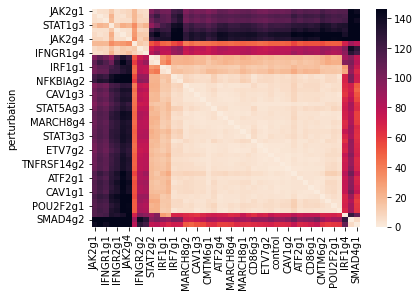

In [6]:
sns.heatmap(ed, robust=True, cmap='rocket_r')
pl.show()

In [7]:
from scipy.cluster import hierarchy

In [9]:
et = pd.read_csv('../snakemake/tables/etest_PapalexiSatija2021_eccite_RNA_tables.csv', index_col=0)

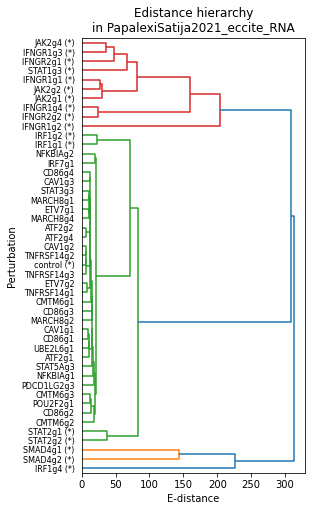

In [13]:
Z = hierarchy.linkage(ed, 'single')
pl.subplots(figsize=(4,8))
dn = hierarchy.dendrogram(Z, orientation='right', labels=ed.index)
pl.ylabel('Perturbation')
pl.title('Edistance hierarchy\nin PapalexiSatija2021_eccite_RNA')
pl.xlabel('E-distance')
labels = [l.get_text() for l in pl.gca().get_yticklabels()]
new_labels = [l+' (*)' if et.loc[l, 'significant_adj'] else l for l in labels]
pl.yticks(pl.gca().get_yticks(), new_labels)
pl.show()

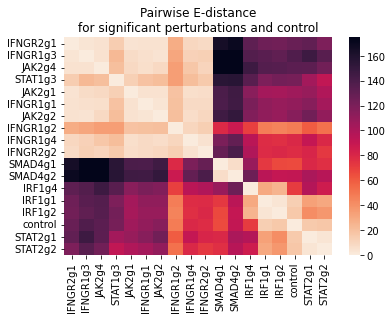

In [21]:
idx = et.index[(et.significant_adj) | (et.index=='control')]
ed_ = ed.loc[idx, idx]
ed_ = cluster_matrix(ed_, 'both')
sns.heatmap(ed_, robust=True, cmap='rocket_r')
pl.title('Pairwise E-distance\nfor significant perturbations and control')
pl.show()

In [ ]:
# IFNGR, IRF1, JAK2, JAK2, SMAD4, STAT1, STAT2
# ATF2, CAV1, CD86, CMTM6, ETV7, IRF7, MARCH8, NFKBIA, UBE2L6, POU2F2, TNFRSF1, STAT3, STAT5, PDCD1LG2
# https://www.researchgate.net/publication/232249411/figure/fig5/AS:667174616186880@1536078232071/IFN-signaling-through-the-Jak-STAT-pathway-Type-I-IFN-as-and-IFN-b-and-type-III.png